In [1]:
%pip install jax[cuda12] numpy matplotlib networkx
import jax, numpy
from jax import numpy as jnp
from matplotlib import pyplot as plt
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

Note: you may need to restart the kernel to use updated packages.


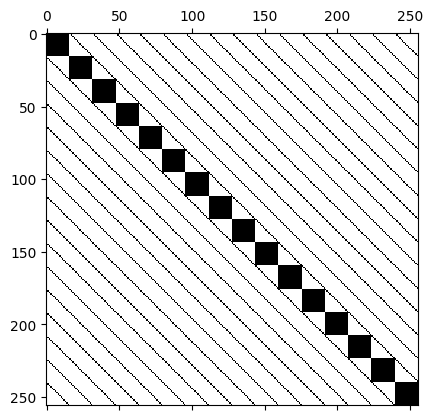

In [2]:
# which core is connected to which other core
num_rows = 16
num_cols = 16
num_slots_out = 4
num_slots_in  = 4
num_neighbors = 31
num_cores = num_rows * num_cols
num_neurons_per_slot = 64

# Connect cores -> baked into the hardware
# Define which cores can talk to which other cores (cores arranged in a grid)
C = jnp.zeros((num_rows, num_cols, num_rows, num_cols), dtype=bool)
# cores are connected along row busses
C = C.at[jnp.arange(num_rows), :, jnp.arange(num_rows), :].set(True)
# cores are connected along column busses
C = C.at[:, jnp.arange(num_cols), :, jnp.arange(num_cols)].set(True)
plt.matshow(C.reshape(num_cores, num_cores), cmap='gray_r')

In [3]:
# Each core has a neighborhood of connected cores. In this neighborhood, each other core's output slots can be connected to input slots
assert jnp.allclose((C.sum(axis=(2, 3))), num_neighbors), f"Every core should have exactly {num_neighbors} neighbors"
# Find each core's neighbors
IDX = jnp.arange(num_cores).reshape(num_rows, num_cols)

# store which core (linearly indexed) has which neighbors (linearly indexed)
N = jnp.zeros((num_cores, num_neighbors), dtype=int)
N_one_hot = jnp.zeros((num_rows, num_cols, num_neighbors, num_rows, num_cols), dtype=bool)
for i in jnp.arange(num_rows):
    for j in jnp.arange(num_cols):
        nzs = jnp.nonzero(C[i,j,...], size=num_neighbors, fill_value=-1)
        # store the IDX of each neighbor (linearly indexed)
        N = N.at[IDX[i,j],:].set(IDX[*nzs])

        # store the one-hot encoding of each neighbor
        N_one_hot = N_one_hot.at[i,j,jnp.arange(num_neighbors),*nzs].set(True)
N, N_one_hot.shape

(Array([[  0,   1,   2, ..., 208, 224, 240],
        [  0,   1,   2, ..., 209, 225, 241],
        [  0,   1,   2, ..., 210, 226, 242],
        ...,
        [ 13,  29,  45, ..., 253, 254, 255],
        [ 14,  30,  46, ..., 253, 254, 255],
        [ 15,  31,  47, ..., 253, 254, 255]], dtype=int32),
 (16, 16, 31, 16, 16))

In [4]:
# Connect slots -> configured by the LUTs
S = jax.random.randint(jax.random.PRNGKey(0), (num_rows, num_cols, num_slots_in, num_neighbors, num_slots_out), 0, 2).astype(bool)
# Compute how all slots are connected
S_flat = jnp.einsum("ijmn,ijqmn,ijkqo->ijkmno", C, N_one_hot, S)

# Define weights -> stored in RRAM
# Each cores slots are connected to other cores slots with a weight matrix
W = jax.random.normal(jax.random.PRNGKey(0), (num_rows, num_cols, num_slots_in, num_neurons_per_slot, num_slots_out, num_neurons_per_slot))
# Compute how all weights are connected
W_flat = jnp.einsum("ijkmno,ijklop->ijklmnop", S_flat, W)

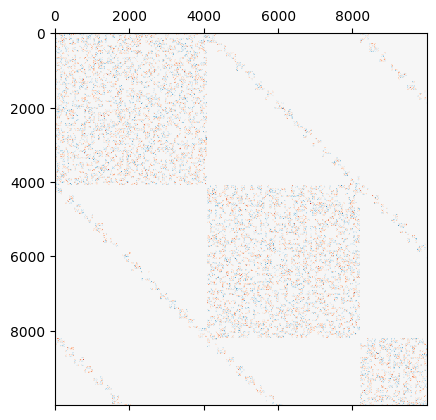

In [11]:
num_neurons_total = num_cores * num_slots_out * num_neurons_per_slot
plt.matshow(W_flat.reshape(num_neurons_total, num_neurons_total)[:10000,:10000], cmap='RdBu_r', vmin=-6, vmax=6)